# Display F=GFS6h fcst, O=HRD dropsondes, diffs. 

Notice that you can jump to the "Jump Here" section and save the slow reading of GFS model data and all the interpolation of model fields onto dropsonde points. 

In [4]:
import pandas as pd
import numpy as np 
import datetime
import xarray as xr 
import matplotlib.pyplot as plt
# import metpy

<a id='Outline'></a>
## Notebook outline: 

[Grab the GFS grids: 6h forecast and 0F (same as analysis?)](#GFSgrids)

[Read dropsondes](#drops)

[Interpolate GFS to drop locations, and write out GFS-augmented drops](#GFSdata)

### Jump here to read from GFS-augmented drops and analyze more
[Differences O-F, O-A, A-F](#O-F)


<a id='GFSgrids'></a>

# Let's get some model grids to compare to 

[Back to Outline](#Outline)

In [2]:
flight_date = '20210828'
HH = 12                 # flight was at roughly 12Z judging from dropsonde times

# Derived strings 
YYYY = flight_date[0:4]
MM = flight_date[4:6]
DD = flight_date[6:8]

fltime = datetime.datetime(int(YYYY),int(MM),int(DD), HH)

# intialization time is flight time minus lead time. 

# Look at 6h forecast: 
lead = 6 # hours
init = fltime - datetime.timedelta(hours=lead)

foldername = str(init.strftime('%Y%m%d'))
filename = str(init.strftime('%Y%m%d%H'))+'.f'+str(lead).zfill(3)
URL = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds084.1/2021/' \
    + foldername+'/gfs.0p25.'+filename+'.grib2'
 
# Open URL as a dataset: GFS 6F = 6-hour forecast 
GFS6F = xr.open_dataset(URL)


# Also grab 0-hour forecast (same as analysis?) for comparison
lead = 0 # hours
init = fltime - datetime.timedelta(hours=lead)
foldername = str(init.strftime('%Y%m%d'))
filename = str(init.strftime('%Y%m%d%H'))+'.f'+str(lead).zfill(3)
URL = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds084.1/2021/' \
    + foldername+'/gfs.0p25.'+filename+'.grib2'
 
# Open URL as a dataset: GFS 6F = 6-hour forecast 
GFS0F = xr.open_dataset(URL)

<a id='drops'></a>

# Now read all the dropsonde
### to define the lat-lon window 

[Back to Outline](#Outline)

In [3]:
# Helper function 
def findall(p, s):
    '''Yields all the positions of the pattern p in the string s.'''
    i = s.find(p)
    while i != -1:
        yield i
        i = s.find(p, i+1)

In [4]:
# Request the response to a directory URL 'https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/'
# and find all filenames ending in .frd

import requests
r = requests.get('https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/')
content = r.text

FRDfiles = []
for i in findall('.frd', content):
    FRDfiles.append(content[i-18:i+4])

# remove duplicates
FRDfiles = list(set(FRDfiles))
# Prepend full path
FRDpaths = ['https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/' +s for s in FRDfiles]
FRDpaths.sort()

In [5]:
droptimes = [ x[65:99] for x in FRDpaths]  # ['D20210828_091908QC.frd','D20210828_093202QC.frd',...]

In [6]:
# Create a list of dataframes, reading the files one by one
# Column names 
cnames = ['IX','t_s','P_mb','T_C','RH','Z_m','WD','WS_ms','U_ms','V_ms','NS','WZ_ms','ZW_m','FP','FT','FH','FW','LAT','LON']

drops = []
for ifile in FRDpaths: 
    print(ifile)
    df = pd.read_csv(ifile, skiprows=21, delim_whitespace=True, names=cnames)
    df.mask((df <= -900), inplace=True)
    drops.append(df)

https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_091908QC.frd
https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_093202QC.frd
https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_094016QC.frd
https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_094454QC.frd
https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_095057QC.frd
https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_100108QC.frd
https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_101114QC.frd
https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_104206QC.frd
https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_105043QC.frd
https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_105831QC.frd
https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/D20210828_110159QC.frd
https://seb.noaa.gov/pub/acdata/

#### Drops plot: no reason to get fussy about horizontal interpolation in 1/4 deg GFS
### Red: 6h forecast, Black: update

Text(0.5, 1.0, 'Red: 6h fcst, Black: Analysis')

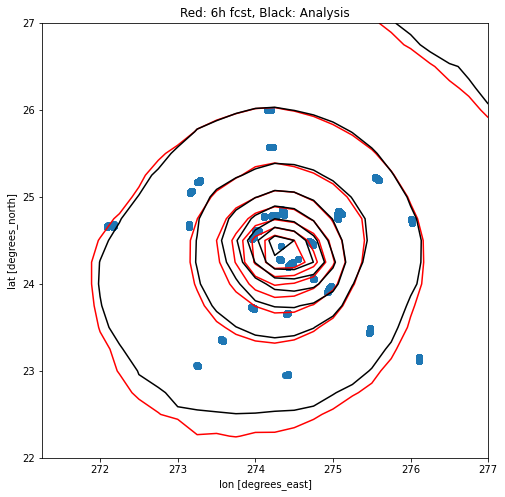

In [9]:
# Plot GFS6F SLP contours and sondes on top 
# Annoyingly, lat slice goes from MAX to MIN, and lon needs 360 added. 

alldrops = pd.concat(drops)

SLP6 = GFS6F['Pressure_reduced_to_MSL_msl'].sel( \
             lon=slice(360+alldrops.LON.min()-1, 360+alldrops.LON.max()+1) ).sel( \
             lat=slice(    alldrops.LAT.max()+1,     alldrops.LAT.min()-1) ).squeeze()

SLP0 = GFS0F['Pressure_reduced_to_MSL_msl'].sel( \
             lon=slice(360+alldrops.LON.min()-1, 360+alldrops.LON.max()+1) ).sel( \
             lat=slice(    alldrops.LAT.max()+1,     alldrops.LAT.min()-1) ).squeeze()

# Drops on SLP contours
fig, ax = plt.subplots(figsize=[8,8])

SLP6.plot.contour( levels=range(95000,102000,400), ax=ax, colors='r')
SLP0.plot.contour( levels=range(95000,102000,400), ax=ax, colors='k')

plt.scatter(360+alldrops.LON, alldrops.LAT)

ax.set_title('Red: 6h fcst, Black: Analysis')

# Grab center position from GFS0 
### to construct radius of each dropsonde point

In [141]:
centerfix = SLP0.argmin(dim=['lat', 'lon']) # Find location of minimum in this area
ilat, ilon = centerfix['lat'].values, centerfix['lon'].values
clat,clon = SLP0.lat[ilat].values, SLP0.lon[ilon].values
print(clat,clon)

for drop in drops:
    drop['radius'] = np.sqrt( (    drop.LAT-clat)**2 + \
                             ((360+drop.LON-clon)*np.cos(clat*np.pi/180))**2 ) *111.111

24.5 274.25


Text(0.5, 1.0, 'T profile colored by radius in km')

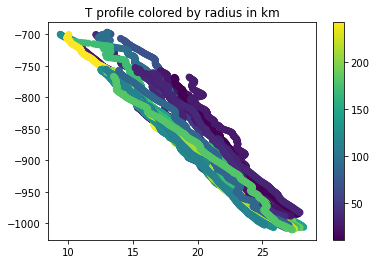

In [95]:
# Quick look of T profiles 
alldrops = pd.concat(drops)

plt.scatter(alldrops.T_C, -alldrops.P_mb, c=alldrops['radius']); plt.colorbar()
plt.title('T profile colored by radius in km')

--------------------
<a id='GFSdata'></a>

# Estimate GFS fields at dropsonde points 
### Select nearest neighbor gridpoint in lat-lon,
### then interpolate using numpy in the vertical 

[Back to Outline](#Outline)

In [40]:
drop.LON.mean() ### MUST ADD 360! or you get Sahara (T~330K!) 

-83.98518439716314

In [41]:
for index,drop in enumerate(drops): 
    print(droptimes[index]) 
    # Sample GFS6F at the dropsonde LAT, LON from first valid datapoint
    G6column = GFS6F.sel(lat=drop.LAT.mean(),lon=drop.LON.mean()+360, method='nearest')
    G0column = GFS0F.sel(lat=drop.LAT.mean(),lon=drop.LON.mean()+360, method='nearest')

    # Get the values to itnerpolate: T,q,u,v in p coordinate
    GFSp = G6column['isobaric'].values
    # 6-hour fcst values
    G6T = G6column['Temperature_isobaric'].values[0]-273.2  # Celsius from Kelvin
    G6u = G6column['u-component_of_wind_isobaric'].values[0]
    G6v = G6column['v-component_of_wind_isobaric'].values[0]
    # 0-hour values
    G0T = G0column['Temperature_isobaric'].values[0]-273.2  # Celsius from Kelvin
    G0u = G0column['u-component_of_wind_isobaric'].values[0]
    G0v = G0column['v-component_of_wind_isobaric'].values[0]

    # To interpolate: get drop profiles as plain old numpy arrays using .values
    patdrop= drop.P_mb.values

    T6atdrop= drop.T_C.values.copy()*0    # right shaped result container with NaNs in right places
    u6atdrop= drop.U_ms.values.copy()*0    # right shaped result container with NaNs in right places
    v6atdrop= drop.V_ms.values.copy()*0    # right shaped result container with NaNs in right places
    
    T0atdrop= drop.T_C.values.copy()*0    # right shaped result container with NaNs in right places
    u0atdrop= drop.U_ms.values.copy()*0    # right shaped result container with NaNs in right places
    v0atdrop= drop.V_ms.values.copy()*0    # right shaped result container with NaNs in right places
    
    # Loop over all non-NAN thermo levels, replacing 0 values with interpolated ones
    print( np.size( np.argwhere( np.isfinite(patdrop) & np.isfinite(T6atdrop) )),'levels with T')
    for i in np.argwhere( np.isfinite(patdrop) & np.isfinite(T6atdrop) ): 
        T6atdrop[i] = np.interp(100*patdrop[i][0],GFSp,G6T)  
        T0atdrop[i] = np.interp(100*patdrop[i][0],GFSp,G0T)  
        
    # Loop over all non-NAN wind levels, replacing 0 values with interpolated ones
    print( np.size(np.argwhere( np.isfinite(patdrop) & np.isfinite(u6atdrop))), 'wind levels')

    for i in np.argwhere( np.isfinite(patdrop) & np.isfinite(u6atdrop) ): 
        u6atdrop[i] = np.interp(100*patdrop[i][0],GFSp,G6u)  
        u0atdrop[i] = np.interp(100*patdrop[i][0],GFSp,G0u)  
        
        v6atdrop[i] = np.interp(100*patdrop[i][0],GFSp,G6v)  
        v0atdrop[i] = np.interp(100*patdrop[i][0],GFSp,G0v)  

    # Add to drop datafrome
    drop['GFS6T'] = pd.Series(T6atdrop)
    drop['GFS6u'] = pd.Series(u6atdrop)
    drop['GFS6v'] = pd.Series(v6atdrop)
    drop['GFS0T'] = pd.Series(T0atdrop)
    drop['GFS0u'] = pd.Series(u0atdrop)
    drop['GFS0v'] = pd.Series(v0atdrop)

D20210828_091908QC.frd
564 levels with T
549 wind levels
D20210828_093202QC.frd
558 levels with T
523 wind levels
D20210828_094016QC.frd
558 levels with T
541 wind levels
D20210828_094454QC.frd
573 levels with T
539 wind levels
D20210828_095057QC.frd
571 levels with T
548 wind levels
D20210828_100108QC.frd
558 levels with T
540 wind levels
D20210828_101114QC.frd
571 levels with T
553 wind levels
D20210828_104206QC.frd
412 levels with T
403 wind levels
D20210828_105043QC.frd
399 levels with T
397 wind levels
D20210828_105831QC.frd
337 levels with T
332 wind levels
D20210828_110159QC.frd
294 levels with T
291 wind levels
D20210828_111333QC.frd
409 levels with T
392 wind levels
D20210828_112119QC.frd
454 levels with T
441 wind levels
D20210828_112720QC.frd
453 levels with T
401 wind levels
D20210828_114408QC.frd
295 levels with T
292 wind levels
D20210828_115408QC.frd
419 levels with T
326 wind levels
D20210828_120338QC.frd
405 levels with T
387 wind levels
D20210828_120554QC.frd
424 leve

# Write out the GFS-augmented dropsonde files 

In [143]:
for i,fname in enumerate(droptimes): 
    print('~/Box/MPO624_data/VP_hurr_sondes/'+flight_date+'I1/'+fname+'.csv')
    drops[i].to_csv('~/Box/MPO624_data/VP_hurr_sondes/'+flight_date+'I1/'+fname+'.csv')

~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_091908QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_093202QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_094016QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_094454QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_095057QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_100108QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_101114QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_104206QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_105043QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_105831QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_110159QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_111333QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_112119QC.frd.csv
~/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_112720QC.frd.csv
~/Box/

<a id='O-F'></a>

# O-F, A-F, O-A
[Back to Outline](#Outline)

In [2]:
# Read augmented drops from disk, saving the time of redoing all the above
FOLDERNAME = r'/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/*.csv'
import glob
import pandas as pd

drops=[]
for file_name in glob.glob(FOLDERNAME):
    print(file_name)
    drop = pd.read_csv(file_name)
    drops.append(drop)

/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_091908QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_093202QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_094016QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_094454QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_095057QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_100108QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_101114QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_104206QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_105043QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_105831QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_sondes/20210828I1/D20210828_110159QC.frd.csv
/Users/brianmapes/Box/MPO624_data/VP_hurr_s

Text(0.5, 1.0, 'O-F for temperature, by radius')

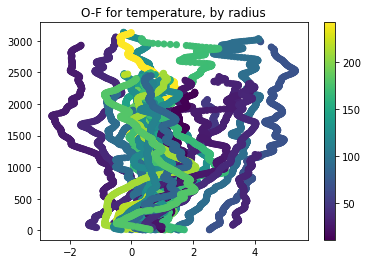

In [5]:
# Scatterplots colored by radius 
alldrops = pd.concat(drops)

O_F = alldrops.T_C - alldrops.GFS6T
O_A = alldrops.T_C - alldrops.GFS0T
A_F = alldrops.GFS0T - alldrops.GFS6T

# Difference plot O-F for all drops: is there a mean bias?
plt.scatter(O_F , alldrops.Z_m, c=alldrops.radius)
plt.set_xlim=[-5,5] # why doesn't this work
plt.colorbar()
plt.title('O-F for temperature, by radius')

Text(0.5, 1.0, 'O-A for temperature, by radius')

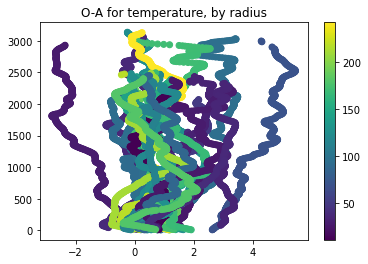

In [6]:
# Difference plot O-A for all drops: smaller, if drops got assimilated... 
plt.scatter(O_A , alldrops.Z_m, c=alldrops.radius)
plt.colorbar()
plt.title('O-A for temperature, by radius')

Text(0.5, 1.0, 'A-F for T at O points, by radius')

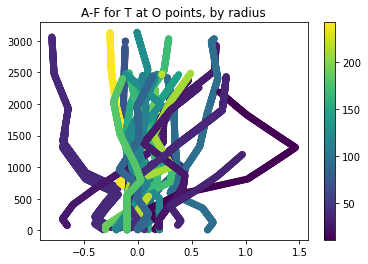

In [7]:
# Analysis increment A-F at dropsonde points
plt.scatter(A_F , alldrops.Z_m, c=alldrops.radius)
plt.colorbar()
plt.title('A-F for T at O points, by radius')

In [8]:
O_F.describe() # there is one outlier of 25, need to mask it out (should find out why it is there)

count    13243.000000
mean         1.057278
std          1.386758
min         -2.581799
25%          0.271521
50%          0.784227
75%          1.639653
max         25.700000
dtype: float64

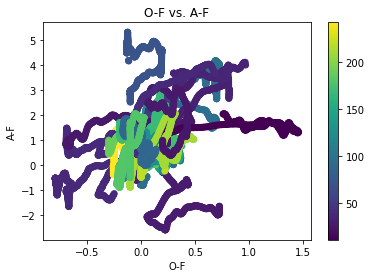

In [9]:
# Is the assimilation increment correlated with O-F ? 
plt.scatter(A_F , O_F.mask(O_F>15), c=alldrops.radius)
plt.colorbar()
plt.xlabel('O-F'), plt.ylabel('A-F')
plt.title('O-F vs. A-F')
plt.set_xlim=[-5,5] # why doesn't this work

In [15]:
alldrops

,Unnamed: 0.1,Unnamed: 0,IX,t_s,P_mb,T_C,RH,Z_m,WD,WS_ms,...,FW,LAT,LON,GFS6T,GFS6u,GFS6v,GFS0T,GFS0u,GFS0v,radius
0,0,0,1,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,0.25,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,3,0.50,NaN,NaN,83.6,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,4,0.75,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,5,1.00,NaN,NaN,83.5,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,914,914,915,228.50,1010.3,27.32,80.9,13.0,134.0,16.72,...,0,24.749,-83.993,26.712402,-13.281294,15.076856,26.612305,-13.361264,15.840977,179.785999
915,915,915,916,228.75,NaN,NaN,NaN,NaN,138.0,17.59,...,0,NaN,NaN,NaN,-0.000000,0.000000,NaN,-0.000000,0.000000,NaN
916,916,916,917,229.00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
917,917,917,918,229.25,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


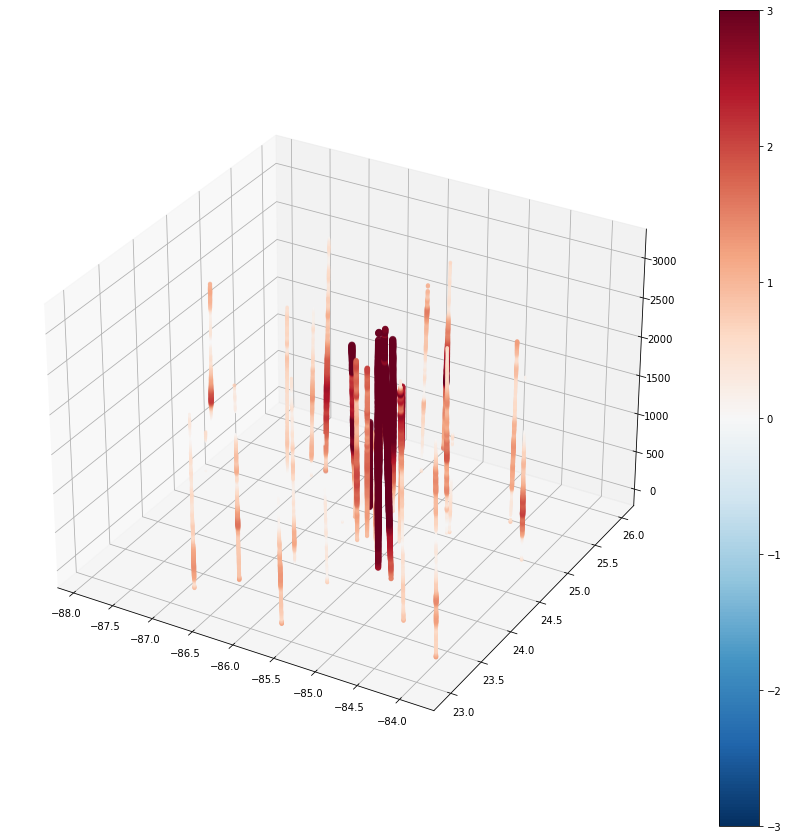

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
dots = ax.scatter3D(alldrops.LON,alldrops.LAT,alldrops.Z_m, vmin=-3,vmax=3, 
                    c=O_F, s=O_F*10, cmap='RdBu_r')
plt.colorbar(dots)

In [14]:
ax.scatter3D?

Signature:
ax.scatter3D(
    xs,
    ys,
    zs=0,
    zdir='z',
    s=20,
    c=None,
    depthshade=True,
    *args,
    data=None,
    **kwargs,
)
Docstring:
Create a scatter plot.

Parameters
----------
xs, ys : array-like
    The data positions.
zs : float or array-like, default: 0
    The z-positions. Either an array of the same length as *xs* and
    *ys* or a single value to place all points in the same plane.
zdir : {'x', 'y', 'z', '-x', '-y', '-z'}, default: 'z'
    The axis direction for the *zs*. This is useful when plotting 2D
    data on a 3D Axes. The data must be passed as *xs*, *ys*. Setting
    *zdir* to 'y' then plots the data to the x-z-plane.

    See also :doc:`/gallery/mplot3d/2dcollections3d`.

s : float or array-like, default: 20
    The marker size in points**2. Either an array of the same length
    as *xs* and *ys* or a single value to make all markers the same
    size.
c : color, sequence, or sequence of colors, optional
    The marker color. Possible valu